In [1]:
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
#style.use('fivethirtyeight')
from mpl_toolkits.mplot3d import Axes3D
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras


import dataset, network, GPR_Model, prob_dist
import WGAN_Model

# Load data

In [2]:
n_features = 4 

data = pd.read_csv("data/mtsdata.csv")
print(data.head())

x1, x2, x3 = np.array(data["Surface Area"]*1e13).reshape(-1,1), np.array(data["Concentration"]).reshape(-1,1), np.array(data["Time"]).reshape(-1,1)

X_train = np.concatenate((x1, x2), axis=1)
X_train = np.concatenate((X_train, x3), axis=1)
y_train = np.array(data["Response"]).reshape(-1,1)

X_test = np.concatenate((x1, x2), axis=1)
X_test = np.concatenate((X_test, x3), axis=1)
y_test = np.array(data["Response"]).reshape(-1,1)


   Surface Area  Time  Concentration  Response
0  1.256640e-15     4           0.25  0.640000
1  1.256640e-15     4           0.25  0.236967
2  1.256640e-15     4           0.25  0.291133
3  1.256640e-15     4           0.25  0.022415
4  1.256640e-15     4           0.25  0.049354


# WGAN

### Preprocessing

In [3]:
wgan = WGAN_Model.WGAN(n_features)

In [4]:
train_dataset, X_train_concat_flatten, scaler,  X_train_concat = wgan.preproc(X_train, y_train)
test_dataset, X_test_concat_flatten, scaler1,  X_test_concat = wgan.preproc(X_test, y_test)

every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (1, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (10, 20, 4, 1)
every time the data shape (1, 20, 4, 1)


### Training

In [5]:
wgan.generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 320)               40960     
_________________________________________________________________
batch_normalization (BatchNo (None, 320)               1280      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                25600     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6400      
_________________________________________________________________
reshape (Reshape)            (None, 20, 4, 1)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 20, 4, 1)          1

In [6]:
hist = wgan.train(train_dataset, epochs=100)

Epoch 0/100
discriminator: -0.179651 - generator: -0.527725 - 8s
Epoch 1/100
discriminator: -0.674692 - generator: -0.072688 - 0s
Epoch 2/100
discriminator: -0.880332 - generator: 0.325397 - 0s
Epoch 3/100
discriminator: -1.494074 - generator: 0.559560 - 0s
Epoch 4/100
discriminator: -1.383794 - generator: 0.453712 - 0s
Epoch 5/100
discriminator: -1.286606 - generator: 0.223520 - 0s
Epoch 6/100
discriminator: -1.369761 - generator: 0.217012 - 0s
Epoch 7/100
discriminator: -1.248895 - generator: 0.017144 - 0s
Epoch 8/100
discriminator: -1.551985 - generator: 0.216279 - 0s
Epoch 9/100
discriminator: -1.427893 - generator: 0.312318 - 0s
Epoch 10/100
discriminator: -1.242030 - generator: 0.476280 - 0s
Epoch 11/100
discriminator: -1.458757 - generator: 0.369132 - 0s
Epoch 12/100
discriminator: -1.435354 - generator: 0.373597 - 0s
Epoch 13/100
discriminator: -0.982883 - generator: 0.355678 - 0s
Epoch 14/100
discriminator: -1.083207 - generator: 0.395781 - 0s
Epoch 15/100
discriminator: -1.25

Loss: 


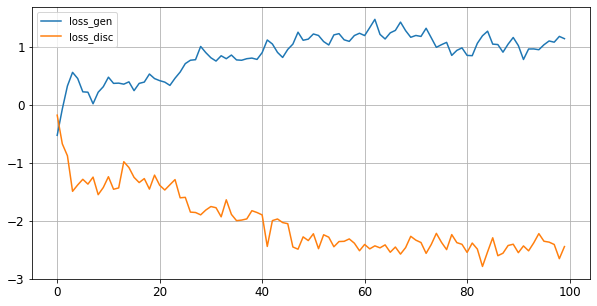

In [7]:
# plot loss
print('Loss: ')
fig, ax = plt.subplots(1,1, figsize=[10,5])
ax.plot(hist)
ax.legend(['loss_gen', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()
plt.show()

In [8]:
X_generated = wgan.predict(X_test_concat_flatten, scaler1, X_test_concat)

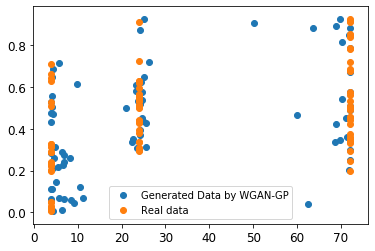

In [9]:
if scenario in ("3d", "helix"):
    ax = plt.subplot(projection='3d')

    ax.scatter(X_generated[:,0], X_generated[:,1], X_generated[:,2], c='b', label='Generated Data')  # 绘制数据点,颜色是红色
    ax.scatter(X_train[:,0], X_train[:,1], y_train, c='r')

    ax.set_zlabel('Z')
    ax.set_ylabel('Y')
    ax.set_xlabel('X')

    plt.legend(loc='best')
    plt.draw()
    
else:
    plt.scatter(X_generated[:,2], X_generated[:,3], label="Generated Data by WGAN-GP")
    plt.scatter(X_train[:,2], y_train, label="Real data")
    plt.legend(loc='best')
    plt.show()

In [10]:
X_generated[:,1].shape
X_train.reshape(-1,1).shape

(270, 1)

# Gaussian Process Regression

In [11]:
ypred_GPR = GPR_Model.train(X_train, y_train, X_test, scenario, n_features)

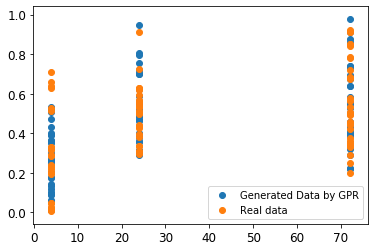

In [12]:
if scenario in ("3d", "helix"):
    ax = plt.subplot(projection='3d')

    ax.scatter(X_test[:,0], X_test[:,1], ypred_GPR, c='b', label='Generated Data')  # 绘制数据点,颜色是红色
    ax.scatter(X_train[:,0], X_train[:,1], y_train, c='r')

    ax.set_zlabel('Z') 
    ax.set_ylabel('Y')
    ax.set_xlabel('X')

    plt.legend(loc='best')
    plt.draw()

else:
    plt.scatter(X_test[:,2], ypred_GPR, label='Generated Data by GPR')
    plt.scatter(X_train[:,2], y_train, label="Real data")
    plt.legend(loc='best')

# Comparison

### Prediction Plots

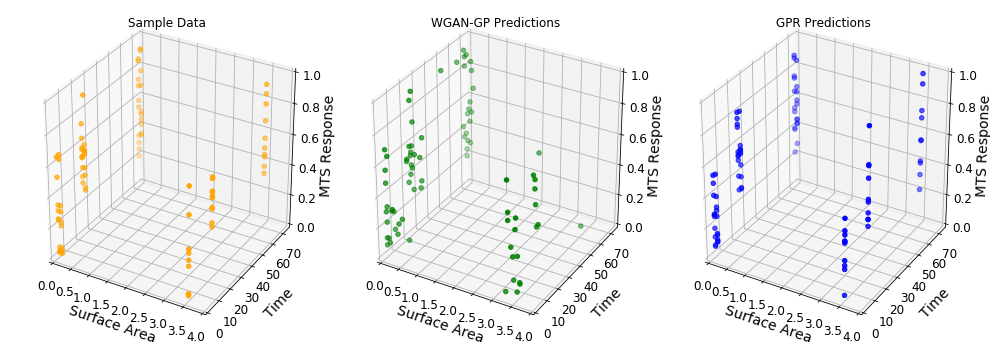

In [23]:
fig = plt.figure(figsize=(13, 4))

#---- First subplot
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(X_test[:,0], X_test[:,2], y_test, color='orange')
ax.set_title("Sample Data")
ax.set_xlabel("Surface Area")
ax.set_ylabel("\n Time")
ax.set_zlabel("MTS Response")
ax.set_xlim(0,4)
ax.set_ylim(-0,75)
ax.set_zlim(0,1)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter(X_generated[:,0], X_generated[:,2], X_generated[:,3], color='green', label='Generated Data')
ax.set_title("WGAN-GP Predictions")
ax.set_xlabel("Surface Area")
ax.set_ylabel("\n Time")
ax.set_zlabel("MTS Response")
ax.set_xlim(0,4)
ax.set_ylim(-0,75)
ax.set_zlim(0,1)


ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(X_test[:,0], X_test[:,2], ypred_GPR, c='b', label='Generated Data')
ax.set_title("GPR Predictions")
ax.set_xlabel("Surface Area")
ax.set_ylabel("\n Time")
ax.set_zlabel("MTS Response")
ax.set_xlim(0,4)
ax.set_ylim(-0,75)
ax.set_zlim(0,1)

plt.tight_layout(pad=-2, w_pad=0.8, h_pad=0)

### Probability Density Plots

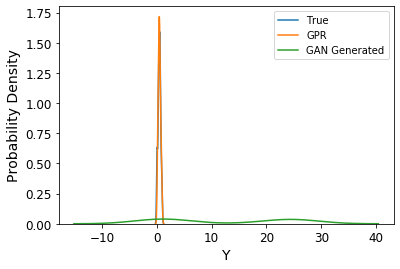

In [14]:
sns.distplot(y_train, hist=False, label='True')
sns.distplot(ypred_GPR, hist=False, label='GPR')
sns.distplot(X_generated[:,1], hist=False, label='GAN Generated')
plt.xlabel("Y")
plt.ylabel("Probability Density")
plt.legend(loc='best');